## A/B Testing to Validate Free Software Advertising Trial

## Table of Contents
- [Introduction](#intro)
- [Part I - Import Data](#data)
- [Part II - Check validity of Experiment Length](#ExpLength)
- [Part III - Verify Invariant Metric for Valid Test](#InvariantMetric)
- [Part IV - Check for Significance in Evaluation Metric](#EvalMetric)
- [Part V - Conclusion](#Conc)

<a id='intro'></a>
### Introduction

The aim of this project is to investigate an advertising strategy of an e-commerce website to determine whether a new call to action (CTA) of a 7-day free software trial resulted in an increased software download rate (Downloads / Cookies (Unique Users) and increased License Sign Up Rate (Licenses / Cookies). The ultimate aim for the company was to increase revenue from Software Sales License Sales.

Business metrics for the trial were based on a proportion of users converted (Downloadin software or purhcasing license) rather than an absolute number. This was to normalize for slightly different volumes of traffic between the test groups.

* Download Rate (Downloads / Cookies (Unique Users)) 
* License Rate (Licenses / Cookies)

Some considerations

- License Rate may lag implementation by a period of 7-days because users are likely to get full value from the free trial.
- Dividing the users by cookies is ineffective if they choose to use incognito mode or a different browser.

<a id='data'></a>
#### Part I - Import Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [2]:
df = pd.read_csv('homepage-experiment-data.csv')

In [3]:
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3


In [4]:
# 29 days of data
df.shape

(29, 7)

In [5]:
#Clean up column names
df.columns = [item.replace(' ','_') for item in df.columns]

In [78]:
ctrl_bins = np.arange(df.Control_Cookies.min(), df.Control_Cookies.max(), 10)
exp_bins = np.arange(df.Experiment_Cookies.min(), df.Experiment_Cookies.max(), 10)

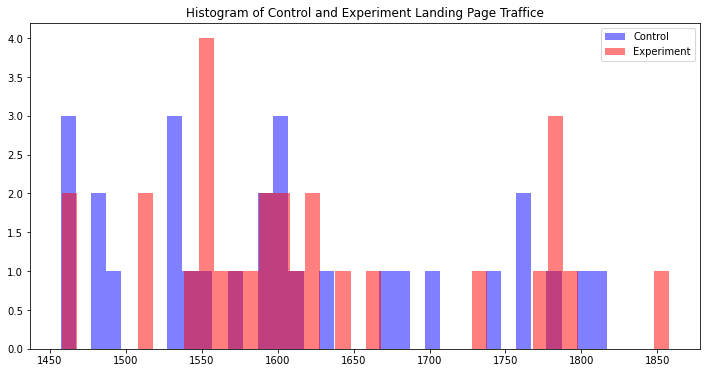

In [79]:
#Plot Raw Data
fig, ax = plt.subplots(figsize=[12,6])

ax.hist(df.Control_Cookies, alpha=0.5, color='b',label='Control', bins=ctrl_bins)
ax.hist(df.Experiment_Cookies, alpha=0.5, color='r',label='Experiment', bins=exp_bins)
plt.title('Histogram of Control and Experiment Landing Page Traffice')
plt.legend(loc='best');

**The data collected does not follow a normal distribution.**

<a id='ExpLength'></a>
#### Part II - Check validity of Experiment Length

Check that this experiment has been run for long enough

We are ensuring that an adequate number of samples have been taken to ensure we don't commit a Type I error below a threshold of 5% and we have a Statistical Power of at least 80%.

In [7]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1-alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(2*p_null*(1-p_null))
    sd_alt  = np.sqrt(p_null*(1-p_null) + p_alt*(1-p_alt))
    
    # Compute and return minimum sample size
    diff = p_alt - p_null
    n =  ((z_null*sd_null - z_alt*sd_alt)/diff)**2
    
    #Create Distributions based on necessary number of trials
    se_null = np.sqrt((p_null*(1-p_null) + p_null*(1-p_null))/n)
    null_dist = stats.norm(loc=0, scale=se_null)
    p_crit = null_dist.ppf(1-alpha)
    
    se_alt = np.sqrt((p_null*(1-p_null) + p_alt*(1-p_alt))/n)
    alt_dist = stats.norm(loc=p_alt-p_null, scale=se_alt)
    #beta = alt_dist.cdf(p_crit)
    
    # Compute distribution heights
    low_bound = null_dist.ppf(.01)
    high_bound = alt_dist.ppf(.99)
    x = np.linspace(low_bound, high_bound, 201)
    y_null = null_dist.pdf(x)
    y_alt = alt_dist.pdf(x)

    # Plot the distributions
    plt.plot(x, y_null)
    plt.plot(x, y_alt)
    plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
               linestyles = '--')
    plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
    plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)

    plt.legend(['null','alt'])
    plt.xlabel('difference')
    plt.ylabel('density')
    plt.show()
    
    return np.ceil(n)

On average this website receives about 3250 unique visitors per day. Therefore, in order to accurately test both the Download and the License Experiments we would require at least 21 days. The experiment has been run for 29 days which is acceptable.

Seven of those days will not be a valid metric for measuring licenses because the trial period last 7 days and the benefit will only be realised after that period.

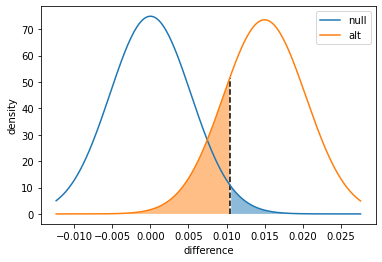

In [8]:
#Min experiment size for Downloads Metric
# 2 * because there are two experiments
dl_min_days = 2*experiment_size(0.16,0.175,alpha=0.025,beta=0.2)/3250

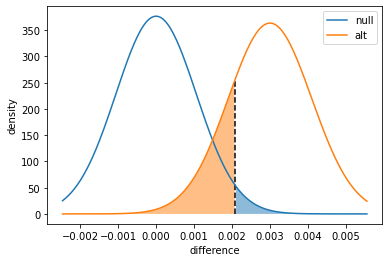

In [9]:
#Min experiment size for License Metric
lic_min_days = 2*experiment_size(0.02,0.023,alpha=0.025,beta=0.2)/3250

In [10]:
print(f'The minimum number of days required is {int(max(dl_min_days,lic_min_days))}')

The minimum number of days required is 21


<a id='InvariantMetric'></a>
#### Part III - Verify Invariant Metric for Valid Test

The experiment was carried out over 29 days, the results are plotted in the histogram above and show that the data does not appear to be normally distributed.

To resolve, this we shall bootstrap the sample data with replacement to estimate the mean and standard deviation of the population. This will enable us to conduct our A/B testing.

We shall then check to see if there is a statistically significant difference between the number of Cookie on the Control and Experiment landing pages

In [11]:
# Bootstrap the aquired data from test period over 10000 trials
ntrials = 10000

stdvals = []
meanvals = []
for i in range(ntrials): 
    sample = np.random.choice(df.Control_Cookies,29)
    meanvals.append(np.mean(sample))
    stdvals.append(np.std(sample))

# Control case mean and std
mu = np.mean(meanvals)
sd = np.mean(stdvals)

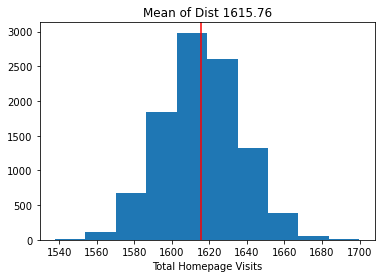

In [14]:
# Plot Bootstrapped Distribution of Control
plt.hist(meanvals)
plt.axvline(mu,label='$\mu = {:.5}$'.format(mu),color='red')
plt.title(f'Mean of Dist {mu:.2f}')
plt.xlabel('Total Homepage Visits');

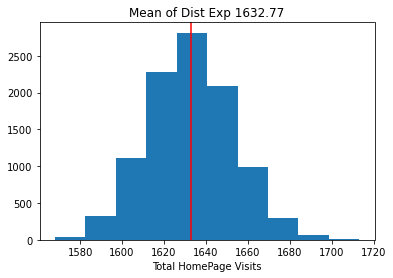

In [15]:
# Repeat process for experiment data
stdvals_exp = []
meanvals_exp = []
for i in range(ntrials): 
    sample = np.random.choice(df.Experiment_Cookies,29)
    meanvals_exp.append(np.mean(sample))
    stdvals_exp.append(np.std(sample))

mu_exp = np.mean(meanvals_exp)
sd_exp = np.mean(stdvals_exp)

plt.hist(meanvals_exp)
plt.axvline(mu_exp,label='$\mu = {:.5}$'.format(mu_exp),color='red')
plt.title(f'Mean of Dist Exp {mu_exp:.2f}')
plt.xlabel('Total HomePage Visits');

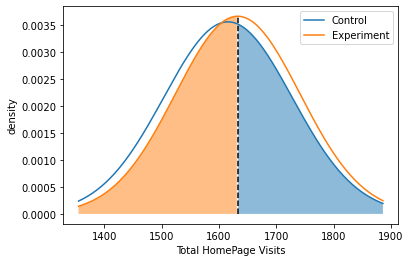

In [16]:
# Compare the distributions
null_dist = stats.norm(loc=mu,scale=sd)
alt_dist = stats.norm(loc=mu_exp, scale = sd_exp)

# Compute distribution heights
low_bound = null_dist.ppf(.01)
high_bound = alt_dist.ppf(.99)
x = np.linspace(low_bound, high_bound, 201)
y_null = null_dist.pdf(x)
y_alt = alt_dist.pdf(x)

p_crit = mu_exp

# Plot the distributions
plt.plot(x, y_null)
plt.plot(x, y_alt)
plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
           linestyles = '--')
plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)

plt.legend(['Control','Experiment'])
plt.xlabel('Total HomePage Visits')
plt.ylabel('density')
plt.show()

In [17]:
pcrit_max = null_dist.ppf(1-0.025)
pcrit_min = null_dist.ppf(0.025)
print(f'Mean of Experiment would have to be <= {pcrit_min:.2f}, or >= {pcrit_max:.2f} to provide certainty of being from a different distribution with alpha = 0.05')

Mean of Experiment would have to be <= 1396.40, or >= 1835.13 to provide certainty of being from a different distribution with alpha = 0.05


It is evident that there is a slight increase in traffic in the Experiment dataset approx 1%, but this is not statistically significant and there is insufficient data to suggest that the experiment is leading to higher traffic on the original home page.

Now that the Invariant Metric has been assessed and deemed acceptable, we can now investigate the Evaluation Metrics.

We could also perform a Welch T-Test on the results. Welch T-Test is a more robust comparison than the students T-Test because it allows for:

- Different Sample Sizes in Null and Alt grounds
- Different variance in groups

Using only emperical data:

In [51]:
# Scipy Welch T-Test - Two sided - Checking for any differing effect on the landing page
stats.ttest_ind_from_stats(df.Experiment_Cookies.mean(),df.Experiment_Cookies.std(), df.Experiment_Cookies.shape[0],
        df.Control_Cookies.mean(), df.Control_Cookies.std(), df.Control_Cookies.shape[0])

Ttest_indResult(statistic=0.5667703149522242, pvalue=0.5731350217922668)

<a id='EvalMetric'></a>
#### Part IV - Check for Significance in Evaluation Metric

In [26]:
df['Control_DR'] = df['Control_Downloads']/df['Control_Cookies']
df['Control_LR'] = df['Control_Licenses']/df['Control_Cookies']

df['Experiment_DR'] = df['Experiment_Downloads']/df['Experiment_Cookies']
df['Experiment_LR'] = df['Experiment_Licenses']/df['Experiment_Cookies']

In [83]:
# Bootstrap the acquired data for Control Downloads
ntrials = 10000

stdvals = []
meanvals = []
for i in range(ntrials): 
    sample = np.random.choice(df.Control_DR,29)
    meanvals.append(np.mean(sample))
    stdvals.append(np.std(sample))

# Control case mean and std
mu_dl_control = np.mean(meanvals)
sd_dl_control = np.mean(stdvals)

In [86]:
# Repeat Bootstrap for Experiment
stdvals = []
meanvals = []
for i in range(ntrials): 
    sample = np.random.choice(df.Experiment_DR,29)
    meanvals.append(np.mean(sample))
    stdvals.append(np.std(sample))

# Control case mean and std
mu_dl_exp = np.mean(meanvals)
sd_dl_exp = np.mean(stdvals)

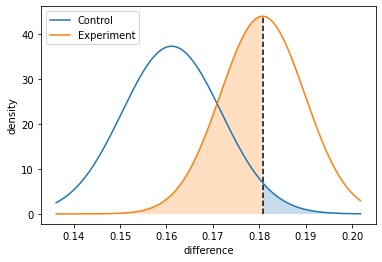

In [87]:
# Compare the distributions
null_dist = stats.norm(loc=mu_dl_control,scale=st_dl_control)
alt_dist = stats.norm(loc=mu_dl_exp, scale = st_dl_exp)

# Compute distribution heights
low_bound = null_dist.ppf(.01)
high_bound = alt_dist.ppf(.99)
x = np.linspace(low_bound, high_bound, 201)
y_null = null_dist.pdf(x)
y_alt = alt_dist.pdf(x)

p_crit = mu_dl_exp

# Plot the distributions
plt.plot(x, y_null)
plt.plot(x, y_alt)
plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
           linestyles = '--')
plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .25)
plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .25)

plt.legend(['Control','Experiment'])
plt.xlabel('difference')
plt.ylabel('density')
plt.show()

In [88]:
print(f'Statistical Power of Experiment {alt_dist.cdf(mu_dl_exp):.2f}')

Statistical Power of Experiment 0.50


In [89]:
print(f'The likelihood of obtaining a mean conversion rate of 0.18% from the Null is {null_dist.sf(mu_dl_exp)*100:.2f}%')

The likelihood of obtaining a mean conversion rate of 0.18% from the Null is 3.35%


The Experiment does seem to indicate a higher conversion rate for downloads, however, the statistical power of this statement is low at 50%.

However, there is less than 5% chance that this conversion rate would be observed during the Control Experiment.

In [57]:
# Check P-Value with Welch TTest
stats.ttest_ind_from_stats(
    df.Experiment_DR.mean(), df.Experiment_DR.std(), df.Experiment_DR.shape[0],
    df.Control_DR.mean(), df.Control_DR.std(), df.Control_DR.shape[0]
)

Ttest_indResult(statistic=7.3912585334754715, pvalue=7.807267675005538e-10)

Welch T-test reaffirms the above results. Evidence from the trial would be sufficient to **Reject the Null**

In [90]:
# Bootstrap the acquired data for Control Licenses
stdvals = []
meanvals = []
for i in range(ntrials): 
    sample = np.random.choice(df.Control_LR,29)
    meanvals.append(np.mean(sample))
    stdvals.append(np.std(sample))

# Control case mean and std
mu_l_control = np.mean(meanvals)
sd_l_control = np.mean(stdvals)

In [91]:
# Bootstrap the acquired data for Experiment Licenses
stdvals = []
meanvals = []
for i in range(ntrials): 
    sample = np.random.choice(df.Experiment_LR,29)
    meanvals.append(np.mean(sample))
    stdvals.append(np.std(sample))

# Control case mean and std
mu_l_exp = np.mean(meanvals)
sd_l_exp = np.mean(stdvals)

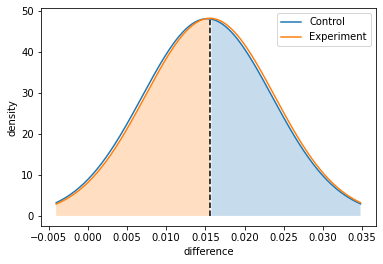

In [93]:
# Compare the distributions
null_dist = stats.norm(loc=mu_l_control,scale=sd_l_control)
alt_dist = stats.norm(loc=mu_l_exp, scale = sd_l_exp)

# Compute distribution heights
low_bound = null_dist.ppf(.01)
high_bound = alt_dist.ppf(.99)
x = np.linspace(low_bound, high_bound, 201)
y_null = null_dist.pdf(x)
y_alt = alt_dist.pdf(x)

p_crit = mu_l_exp

# Plot the distributions
plt.plot(x, y_null)
plt.plot(x, y_alt)
plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
           linestyles = '--')
plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .25)
plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .25)

plt.legend(['Control','Experiment'])
plt.xlabel('difference')
plt.ylabel('density')
plt.show()

In [94]:
# Check P-Value with Welch TTest
stats.ttest_ind_from_stats(
    df.Experiment_LR.mean(), df.Experiment_LR.std(), df.Experiment_LR.shape[0],
    df.Control_LR.mean(), df.Control_LR.std(), df.Control_LR.shape[0]
)

Ttest_indResult(statistic=0.16456042063941873, pvalue=0.8698825444862426)

Welch T-test reaffirms the above results. Evidence from the trial would be insufficient to **Reject the Null**

There would be no evidence to suggest that increased advertisement of the free trial would increaese License Sign Up Rate.

<a id='Conc'></a>
#### Conclusion

The aim of this project was to investigate an advertising strategy of an e-commerce website to determine whether a new call to action (CTA) of a 7-day free software trial resulted in an increased software download rate (Downloads / Cookies (Unique Users) and increased License Sign Up Rate (Licenses / Cookies). The ultimate aim for the company was to increase revenue from Software Sales License Sales.

The business metrics described above were normalized to prevent different website traffic impact the results between the test groups.

An evaluation of the experiment concluded that it had be conducted for an appropriate length of time ( > 21 days) to measure an increase in download rate of 1.5% and increase in license sign up rate of 0.2%. The experiment was actually conducted over a 29 day period which is long enough to account for fluctuations in weekly and daily traffic and purchases.

A check of the invariant metric (Traffic to both Control and Experiment landing pages) concluded that a fair test had been conducted. The average number of visitors to both the control and experiment were not statistically different, despite the new page having slightly (~1%) more traffic over the observation period.

The 7-day free trial call to action conclusively demonstrated an increase in download rates, albeit small at +1.5% which equates to approximately 4 additional downloads per day, however it was unable to demonstrate a statistically significant difference in license purchases.

This may be attributed to the fact that more users are simply downloading the software when they have no real desire/requirement to purchase the final product. Further data would need to be gathered on customers to fully justify this argument.
